In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [2]:
import importlib
import sys
sys.path.append('../../')
import src
importlib.reload(src)

<module 'src' (namespace)>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import numpy as np
from scipy.io import loadmat, savemat
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils
import src.eikonal as eikonal
# import src.openst.OpenST as ost
import timeit
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [4]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.backend import tf
# import tensorflow as tf
from keras.engine.topology import Layer
import keras
from keras.constraints import NonNeg, MinMaxNorm
from IPython.display import clear_output

## Model with high local anomaly

In [8]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
X, Z = np.meshgrid(x, z, indexing='ij')

vmin, vmax = 3000.0, 1000.0
ixc, izc = 30, 30
V = eikonal.gaussian(X, Z, ixc, izc, vmin, vmax, 100.0, 100.0)
# V = np.full_like(V, vmin)

In [31]:
ixs, izs = 10, 10
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
V_scaled = V / V.max()
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

R = np.linalg.norm(np.stack([X_scaled, Z_scaled], axis=-1), axis=-1)
B = np.full_like(R, -1.0)
B[R == 0] = 0.0
# B = eikonal.vgrad_neighbours(B, X_scaled, Z_scaled, V_scaled, ixs, izs, all=True)

In [36]:
CoordLimLow = np.array([xmin, zmin])
CoordLimHigh = np.array([xmax, zmax])
GridSize = np.array([nx, nz])
GridStep = (CoordLimHigh - CoordLimLow) / (GridSize - 1)

T_FSM = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, sou)
B[Z == 0] = T_FSM[Z == 0] * V.max() / scaler

In [ ]:
dx = x[1] - x[0]
dz = z[1] - z[0]
grad_x, grad_z = np.gradient(T_FSM, dx, dz)
grad = np.stack([grad_x, grad_z], axis=-1)

grad_norm = grad / np.linalg.norm(grad, axis=-1, keepdims=True) + 1e-16

In [32]:
data_inhomo = eikonal.prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel(), B.ravel()], 
                             ['input_x', 'input_y', 'velocity', 'bounds'])

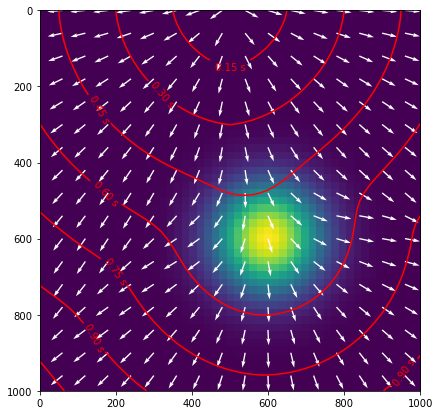

In [20]:
step = 3

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_ = grad_norm[::step, ::step, 0]
V_ = -grad_norm[::step, ::step, 1]

plt.figure(figsize=(15,10))

extent=(xmin, xmax, zmin, zmax)

plt.subplot(121)
plt.imshow(V.T, extent=(xmin, xmax, zmax, zmin))
cs = plt.contour(T_FSM.T, colors='r', extent=extent)
# plt.colorbar(mappable=img, ax=ax, fraction=1/22)
plt.clabel(cs, cs.levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
plt.ylim([zmax, zmin])
plt.quiver(X_, Z_, U_, V_, scale=25, color='white')
plt.axis('scaled')

plt.show()

In [33]:
step_i, step_j = 1, 1

data, indices = eikonal.expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=step_i, step_j=step_j, start=1, enhance=False, freq=1)

data_f, indices_f = eikonal.expansion_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=step_i, step_j=step_j)

# data_c, indices_c = eikonal.contraction_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B], 
#                                   names=['input_x', 'input_y', 'velocity', 'bounds'],
#                                   center=(ixs, izs), step_i=step_i, step_j=step_j, enhance=True)

# data_cl, indices_cl = eikonal.сlosing_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B], 
#                                   names=['input_x', 'input_y', 'velocity', 'bounds'],
#                                   center=(ixs, izs), step_i=step_i, step_j=step_j, enhance=True)

## FCNN model

In [14]:
models = eikonal.forward_model(nh=50, layers=3, shape=(1,), activation='tanh', act_constraints=None,
                            lr=5e-4, decay=1e-5, init='glorot_normal', Blambda=1.0, Mlambda=1.0, 
                            Llambda=1e-4, Plambda=0.0, monotonity_dxy=False)

model_time, model_grad, model_E, model_B, model_M, model_L, model_P = models
model_E.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_y (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           input_x[0][0]                    
                                                                 input_y[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None

784
MAE = 200.994 ms, 38.10 %


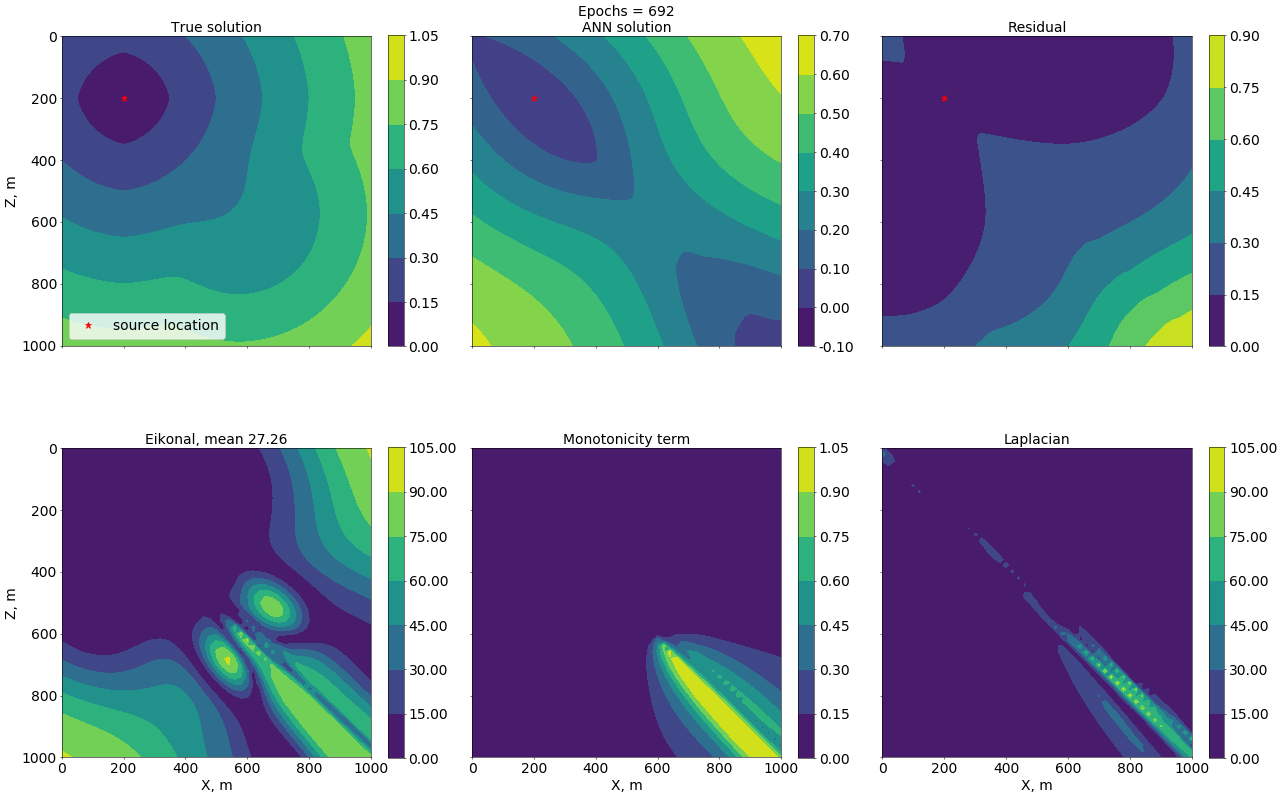

In [ ]:
%%time

input_test = data_inhomo
T_true = T_FSM
# T_true = R / vmin * scaler

epochs = np.linspace(1000, 250, len(data), dtype=int)
start = 0
k = 1
for i in range(start, len(data)):
    input_train = data[k*i]
    output_train = data[k*i]['bounds']
    batch_size = len(output_train)


    model_E.fit(
        input_train, 
        output_train, 
        batch_size=batch_size,
        epochs=epochs[k*i],
        shuffle=True,
        validation_split=.0,
        verbose=0,
#         callbacks=[plot_losses]
    )

    clear_output(wait=True)
    T_pred = model_time.predict(input_test) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
    print(batch_size)
    MAE = abs(T_pred_2d - T_true)
    MAE[ixs, izs] = 0
    rMAE = MAE / (T_true + 1e-16) * 100
    
    eik = model_E.predict(input_test).reshape(T_true.shape)
    eik_r = abs(eik) * V_scaled**2 * 100
    dot_term = model_M.predict(input_test).reshape(T_true.shape)
    laplacian = model_L.predict(input_test).reshape(T_true.shape)
    
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_true.T, T_pred_2d.T, MAE.T], [eik_r.T, dot_term.T, laplacian.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs[k*i]), 'Residual'], 
                                         ['Eikonal, mean {0:.2f}'.format(eik_r.mean()), 'Monotonicity term', 'Laplacian']], 
                            sources=[[sou, sou, sou], [None]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (30, 20),  
                            fontsize=20, imshows=False, colorbars=True)
    
    for j in [1,]:
        axes[0,j].plot(np.take(x, indices_f[i])[:,0], np.take(z, indices_f[i])[:,1], '.k')
        axes[0,j].plot(sou[0], sou[1], '*r', ms=10)

    plt.show()

In [ ]:
model_t.save('../../nn_models/model_t_local_high')
model_eikonal.save('../../nn_models/model_eikonal_local_high')
model_vectorfield.save('../../nn_models/model_vectorfield_local_high')

In [20]:
T_FSM = np.load('../../data/fsm_local_high.npy')

In [ ]:
fsm_grad = np.array(np.gradient(T_FSM, dx, dz))
fsm_modul = np.linalg.norm(fsm_grad, axis=-1, keepdims=True) + 1e-16
fsm_grad_norm = fsm_grad / fsm_modul

pred_grad = model_vectorfield.predict(input_test) / V.max()
pred_grad = pred_grad.reshape(T_pred_2d.shape + (2,))
pred_modul = np.linalg.norm(pred_grad, axis=-1, keepdims=True) + 1e-16
pred_grad_norm = pred_grad / pred_modul

step = 3

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = fsm_grad_norm[::step, ::step, 0]
V_1 = -fsm_grad_norm[::step, ::step, 1]

U_2 = pred_grad_norm[::step, ::step, 0]
V_2 = -pred_grad_norm[::step, ::step, 1]

In [23]:
T_pred_2d -= T_pred_2d.min()

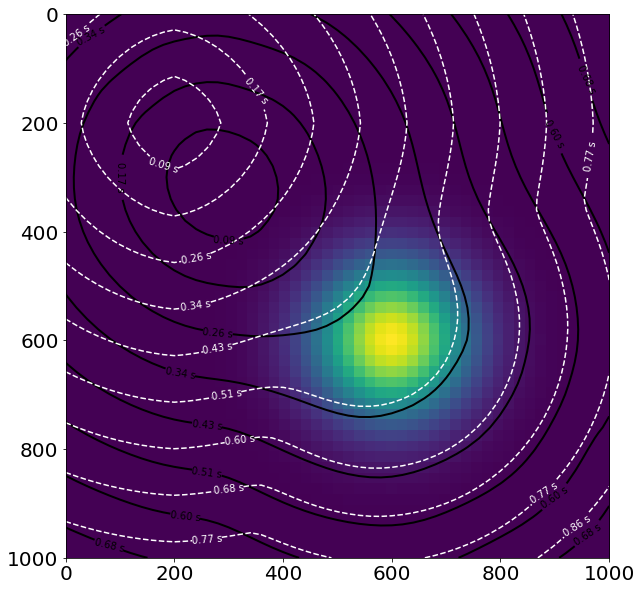

In [24]:
plt.figure(figsize=(15,10))

extent=(x.min(), x.max(), z.min(), z.max())

plt.imshow(V.T, extent=(xmin,xmax,zmax,zmin))

levels = np.linspace(0, T_FSM.max(), 12)

cs1 = plt.contour(T_pred_2d.T, extent=extent, levels=levels, colors='k', linewidths=2)
plt.clabel(cs1, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
# plt.quiver(X_, Z_, U_1, V_1, scale=20, color='k', ls='-')

cs2 = plt.contour(T_FSM.T, extent=extent, levels=levels, colors='w', linestyles='--')
plt.clabel(cs2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
# plt.quiver(X_, Z_, U_2, V_2, scale=20, color='w', ls='-')

plt.ylim([z.max(), z.min()])
plt.axis('scaled')

plt.show()

## Model with low local anomaly

In [ ]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
X, Z = np.meshgrid(x, z, indexing='ij')

vmin, vmax = 4000.0, 1000.0
ixc, izc = 30, 30
V = gaussian(X, Z, ixc, izc, vmin, vmax, 100.0, 100.0)

In [ ]:
ixs, izs = 10, 10
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
V_scaled = V / V.max()
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

R = np.linalg.norm(np.stack([X_scaled, Z_scaled], axis=-1), axis=-1)
B = np.full_like(R, -1.0)
B[R == 0] = 0.0

In [ ]:
CoordLimLow = np.array([xmin, zmin])
CoordLimHigh = np.array([xmax, zmax])
GridSize = np.array([nx, nz])
GridStep = (CoordLimHigh - CoordLimLow) / (GridSize - 1)

T_FSM = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, sou)

In [ ]:
dx = x[1] - x[0]
dz = z[1] - z[0]
grad_x, grad_z = np.gradient(T_FSM, dx, dz)
grad = np.stack([grad_x, grad_z], axis=-1)

grad_norm = grad / np.linalg.norm(grad, axis=-1, keepdims=True) + 1e-16

data_inhomo = prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel(), B.ravel(), T_FSM], 
                             ['input_x', 'input_y', 'velocity', 'out', 'true'])

In [ ]:
step = 3

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_ = grad_norm[::step, ::step, 0]
V_ = -grad_norm[::step, ::step, 1]

plt.figure(figsize=(15,10))

extent=(xmin, xmax, zmin, zmax)

plt.subplot(121)
plt.imshow(V.T, extent=(xmin, xmax, zmax, zmin))
cs = plt.contour(T_FSM.T, colors='r', extent=extent)
# plt.colorbar(mappable=img, ax=ax, fraction=1/22)
plt.clabel(cs, cs.levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
plt.ylim([zmax, zmin])
plt.quiver(X_, Z_, U_, V_, scale=25, color='white')
plt.axis('scaled')

plt.show()

In [ ]:
data, indices = expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=1, step_j=1, start=1)



In [ ]:
model_t, model_eikonal, model_vectorfield = eikonal.init_model(
                                    nh=50, layers=3, shape=(1,), activation='tanh', 
                                    lr=3e-3, decay=1e-4, init='glorot_normal', 
                                    include_velocity=False, blambda1=1.0, blambda2=0.0, blambda3=0.0, 
                                    monotonity_dxy=True, monotonity_drdxy=False, mlambda1=0.5, mlambda2=0.25)
model_eikonal.summary()

In [ ]:
%%time
input_test = data_inhomo
T_true = T_FSM

epochs = np.linspace(2500, 100, len(data), dtype=int)
# epochs = 10
M = model_eikonal
k = 1
for i in range(0, len(data)):
    input_train = data[k*i]
    output_train = data[k*i]['bounds']
    batch_size = len(output_train)


    M.fit(
        input_train, 
        output_train, 
        batch_size=batch_size,
        epochs=epochs[k*i],
        shuffle=True,
        validation_split=.0,
        verbose=0,
#         callbacks=[plot_losses]
    )

    clear_output(wait=True)
    T_pred = model_t.predict(input_test) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
    print(batch_size)
    MAE = abs(T_pred_2d - T_true)
    MAE[ixs, izs] = 0
    rMAE = MAE / (T_true + 1e-16) * 100
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_FSM.T, T_pred_2d.T, MAE.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs[k*i]), 'Residual']], 
                            sources=[[sou, sou, sou]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (18, 12),  
                            fontsize=20, imshows=False, colorbars=True)

    plt.show()

In [ ]:
tau_grad = t_vfield_vgrad(X, Z, xs, zs, vmin, a)
tau_modul = np.linalg.norm(tau_grad, axis=-1, keepdims=True) + 1e-16
tau_grad_norm = tau_grad / tau_modul

pred_grad = model_vectorfield.predict(input_test) / V.max()
pred_grad = pred_grad.reshape(T_pred_2d.shape + (2,))
pred_modul = np.linalg.norm(pred_grad, axis=-1, keepdims=True) + 1e-16
pred_grad_norm = pred_grad / pred_modul

diff_grad = np.linalg.norm(tau_grad - pred_grad, axis=-1)
r_diff_grad = diff_grad / tau_modul.squeeze() * 100

step = 2

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = tau_grad_norm[::step, ::step, 0]
V_1 = -tau_grad_norm[::step, ::step, 1]

U_2 = pred_grad_norm[::step, ::step, 0]
V_2 = -pred_grad_norm[::step, ::step, 1]

<hr>

In [ ]:
MAE = abs(T_pred_2d - tau)
rMAE = MAE / (tau + 1e-16) * 100
rMAE[ixs, izs] = MAE[ixs, izs]

In [ ]:
imgs = [[V.T / 1000, tau.T, T_pred_2d.T]]
quiver = [[None, [X_, Z_, U_1, V_1], [X_, Z_, U_2, V_2]]]
sources = [[sou, sou, sou, sou, sou]]
cols_names = [['Velocity model', 'Analytical solution', 'Neural network solution', 'Relative absolute error of traveltimes', 'Relative error of gradient']]
imshows = [[True, False, False, True, True]]
colorbars = True
cbar_labels = [['velocity, km/s', 'traveltime, sec', 'traveltime, sec', 'traveltime error, %', 'gradient error, %']]
figsize = (35, 20)
fontsize = 25

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, quiver=quiver, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        sources=sources, extent=(xmin,xmax,zmin,zmax), source_size=15, figsize=figsize, fontsize=fontsize,)

plt.show()

In [ ]:
imgs = [[rMAE.T, r_diff_grad.T]]
quiver = None
sources = np.array(sou)
cols_names = [['Relative absolute error of traveltimes', 'Relative error of gradient']]
imshows = True
colorbars = True
cbar_labels = [['traveltime error, %', 'gradient error, %']]
figsize = (22, 15)
fontsize = 25
extent=(xmin,xmax,zmin,zmax)

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, quiver=quiver, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        sources=sources, extent=extent, source_size=15, figsize=figsize, fontsize=fontsize,legend=False)

plt.show()

In [ ]:
extent = (x.min(), x.max(), z.min(), z.max())

mae = abs(tau - T_pred_2d) / tau * 100
mae[ixs, izs] = 0
# mae2 = abs(tau - result[1]) / (tau + 1e-16) * 100

fsm = FSM[ixs,izs]
fsm_mae = abs(tau - fsm) / (tau + 1e-16) * 100

imgs = [[tau.T * 1000, fsm.T * 1000, fsm_mae.T], 
        [tau.T * 1000, T_pred_2d.T * 1000, mae.T]]

cols_names = [['Аналитическое решение', 'Решение FSM', 'Относительна ошибка, mae {0:.2f} %'.format(fsm_mae.mean())], 
              ['Аналитическое решение', 'Решение нейронной сети', 'Относительна ошибка, mae {0:.2f} %'.format(mae.mean())]]

imshows = False
colorbars = [[True, True, True], 
             [True, True, True], 
             [True, True, True]]
cbar_labels = [['время, мс', 'время, мс', 'ошибка, %'], 
               ['время, мс', 'время, мс', 'ошибка, %']]

sources = [[sou, sou, sou],[sou, sou, sou]]
source_label = 'положение источника'

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        figsize=(25,14), extent=extent, sources=sources, source_label=source_label,
                        source_size=12)

plt.show()

In [ ]:
N = 13
plt.figure(figsize=(12,6))
plt.plot(T_true[:,N], '-*r', label='True')
plt.plot(T_pred_2d[:,N])
plt.legend(loc='best')
plt.show()

In [ ]:
def update_images(axes, imgs, indices, extent, source=None, imshow=False):
    images = []

    for i in range(len(imgs)):
        if imshow:
            upd = axes[indices[i]].imshow(imgs[i], extent=extent)
        else:
            upd = axes[indices[i]].contourf(imgs[i], extent=extent)
            axes[indices[i]].set_ylim([imgs[i].shape[1]-1, 0])
            axes[indices[i]].axis('scaled')

    if source is not None:
        if i + j == 0:
            axes[indices[i]].plot(source[0], source[1], 'r*', ms=source_size, label='source location')
            upd = axes[indices[i]].legend(loc='lower left', fontsize=fontsize)
        else:
            upd = axes[indices[i]].plot(source[0], source[1], 'r*', ms=source_size)
    images.append(upd)

    return images

In [ ]:
imags = []

indices = [(0,1), (0,2)]
for i in range(0, end):
    imag = np.concatenate((pred_u[:, i], mae[:, i]), axis=0)
    print(imag.shape)
    ims = update_images(axes, imgs=imag, indices=indices, extent=(0,2000,0,2000))
    imags.append(ims)

anim = anm.ArtistAnimation(fig, imags, interval=150, blit=True, repeat = True)

anim.save('eikonal_vgrad.gif', dpi=50, writer='imagemagick')

In [ ]:
def discretization(X, nearest_up=1, nearest_down=1, 
                   nearest_left=1, nearest_right=1,
                   step_i=1, step_j=1):
    assert len(X.shape) == 2

    n_cols = X.shape[1] - nearest_left - nearest_right
    n_rows = X.shape[0] - nearest_up - nearest_down

    N = n_cols * n_rows
    N_iter = np.array(np.arange(0, N, 1)).reshape((n_rows, n_cols))
    N_iter = N_iter[::step_i, ::step_j]
    N_iter = np.ravel(N_iter)

    batch_cols = nearest_left + nearest_right + 1
    batch_rows = nearest_up + nearest_down + 1
    batch_size = batch_cols * batch_rows

    batches = np.zeros((N, batch_rows, batch_cols))

    center_indices = []
    scheme_indices = []
    for k, Nk in enumerate(N_iter):

        i = int(Nk // n_cols)
        j = int(Nk % n_cols)

        ik = i + nearest_up
        jk = j + nearest_left
      
        inds_k = []
        for l in range(batch_size):

            il = int(l // batch_cols)
            jl = int(l % batch_cols)

            batches[k, il, jl] = X[il + i, jl + j]
            inds_k.append((il + i, jl + j))

        center_indices.append((ik, jk))
        scheme_indices.append(inds_k)

    return batches, center_indices, scheme_indices

def discretization_crest(X, nearest_up=1, nearest_down=1, 
                         nearest_left=1, nearest_right=1,
                         step_i=1, step_j=1):
    assert len(X.shape) == 2

    n_cols = X.shape[1] - nearest_left - nearest_right
    n_rows = X.shape[0] - nearest_up - nearest_down

    N = n_cols * n_rows
    N_iter = np.array(np.arange(0, N, 1)).reshape((n_rows, n_cols))
    N_iter = N_iter[::step_i, ::step_j]
    N_iter = np.ravel(N_iter)

    batch_cols = nearest_left + nearest_right + 1
    batch_rows = nearest_up + nearest_down
    batch_size = batch_cols + batch_rows

    batches = np.zeros((N, batch_size)) #

    center_indices = []
    scheme_indices = []
    for k, Nk in enumerate(N_iter):

        i = int(Nk // n_cols)
        j = int(Nk % n_cols)

        ik = i + nearest_up
        jk = j + nearest_left
      
        inds_k = []
        for l in range(nearest_left + nearest_right + 1):

            jl = jk + l - nearest_left
            batches[k, l] = X[ik, jl]
            inds_k.append((ik, jl))

        mi = 0
        for m in range(nearest_down + nearest_up + 1):
        
            im = ik + m - nearest_up
            if im != ik:
                batches[k, batch_cols + mi] = X[im, jk]
                inds_k.append((im, jk))
                mi += 1

        center_indices.append((ik, jk))
        scheme_indices.append(inds_k)

    return batches, center_indices, scheme_indices

In [ ]:
batches, c_indexes, s_indexes = discretization_crest(X.squeeze(), 
                                                     nearest_up=1, nearest_down=1, 
                                                     nearest_left=2, nearest_right=2,
                                                     step_i=5, step_j=6)

In [ ]:
arr_s_indexes = np.array(s_indexes)
arr_c_indexes = np.array(c_indexes)

print(batches[0])

print([X.squeeze()[ind] for ind in s_indexes[0]])

In [ ]:
M = np.arange(0, 48)
plt.figure(figsize=(10,10))
plt.imshow(V.squeeze())
for m in M:
    plt.scatter(arr_s_indexes[m,:,1], arr_s_indexes[m,:,0], marker='o', s=10)
    plt.scatter(arr_c_indexes[m,1], arr_c_indexes[m,0], marker='*', c='k', s=25)
plt.show()

In [ ]:
x = np.linspace(-4, 5, 51)
y = np.linspace(-3, 6, 51)
X, Y = np.meshgrid(x, y, indexing = 'ij')

batches, indices = expansion_batches(arrays=[X, Y], names=['X', 'Y'], center=(4,3), step_i=1, step_j=1)


In [ ]:
arr_indices = np.array(indices)

In [ ]:
arr_indices[5][:][0]

In [ ]:
M = 46
plt.figure(figsize=(6,6))
plt.imshow(np.ones((51, 51)))
for arr in arr_indices[M]:
    plt.plot(arr[0], arr[1], '.k')
plt.plot(25, 25, '*r', ms=12)
plt.show()